In [733]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from datetime import datetime
from math import sqrt

from scipy.stats import linregress
from numpy import array

In [734]:
df = pd.read_excel('Dados.xlsx')

In [735]:
df['ANOMES'] = pd.to_datetime(df['ANOMES'], format="%d/%m/%Y")
df['USD_2_BRL_Variation']=(df['Câmbio'].astype(float)).pct_change()
df['SELIC'] = df['SELIC']*100
df['fator_selic'] = 1+(df['SELIC'].astype(float))/100
df['Câmbio'] = df['Câmbio']/10000

In [736]:
#BASE INFLAÇÃO
df_inf = df.copy()
df_inf['fator'] = 1+(df['IPCA'].astype(float))/100

df_inf['fator_acumulado']=1.000000
df_inf['fator_acumulado'][0]=df_inf['fator'][0]
for i in range(1, len(df)):
    df_inf['fator_acumulado'][i] = df_inf['fator'][i]*df_inf['fator_acumulado'][i-1]
df_inf['Inflacao_12_Meses']=(df_inf['fator_acumulado']/df_inf['fator_acumulado'].shift(12)-1)*100

df_inf['Inflacao_12_Meses_Shift']=df_inf['Inflacao_12_Meses'].shift(-12)

C:\Users\chris\AppData\Local\Temp\ipykernel_21088\497968519.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inf['fator_acumulado'][0]=df_inf['fator'][0]
C:\Users\chris\AppData\Local\Temp\ipykernel_21088\497968519.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inf['fator_acumulado'][i] = df_inf['fator'][i]*df_inf['fator_acumulado'][i-1]


In [743]:
#INFLAÇÃO

X=df_inf.dropna(how='any')[['IPCA', 'fator_selic','USD_2_BRL_Variation','Inflacao_12_Meses', 'PIM']]
Y=df_inf.dropna(how='any')['Inflacao_12_Meses_Shift']

for column in X.columns:
        x=np.array(X[column],dtype=np.float32)
        y=np.array(Y,dtype=np.float32)
        slope, Intercept, r_value, p_value, std_err = linregress(x,y)
        print('Analysis for: ' + column +' vs Future Inflation:')
        print('p_value: '+str(p_value))
        print('R-Squared: '+str(r_value**2))

Analysis for: IPCA vs Future Inflation:
p_value: 5.048091038026004e-20
R-Squared: 0.22796744894873763
Analysis for: fator_selic vs Future Inflation:
p_value: 1.5688958689336216e-10
R-Squared: 0.1185300957809344
Analysis for: USD_2_BRL_Variation vs Future Inflation:
p_value: 0.9058682987483051
R-Squared: 4.309129448034037e-05
Analysis for: Inflacao_12_Meses vs Future Inflation:
p_value: 7.028028356780002e-21
R-Squared: 0.23718756252737888
Analysis for: PIM vs Future Inflation:
p_value: 0.0005114525982611389
R-Squared: 0.036522421855159796


In [745]:
df_inf=df_inf.dropna(subset=['IPCA', 'SELIC','USD_2_BRL_Variation','Inflacao_12_Meses', 'PIM','Inflacao_12_Meses_Shift']).reset_index(drop=True)

In [746]:
#model construction
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [747]:
n_steps=12
n_features=X.values.shape[1]

In [748]:
n_neurons_dense=64
dropout_ratio=0.3
model=Sequential()
model.add(LSTM(100,dropout=dropout_ratio,recurrent_dropout=dropout_ratio,input_shape=(n_steps,n_features)))
model.add(Dropout(dropout_ratio))
model.add(Dense(n_neurons_dense,activation='tanh'))
model.add(Dropout(dropout_ratio))
model.add(Dense(n_neurons_dense/2,activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(n_neurons_dense/(2**2),activation='softmax'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1,activation='linear'))

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))

In [749]:
def split_sequence(df,Y,n_steps):
  columns=list(df.columns)
  X, y = list(), list()
  for i in range(len(df)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(df)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = df[columns][i:end_ix].values, Y[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y).reshape(-1,1)

In [750]:
X,Y=split_sequence(df_inf[['IPCA', 'SELIC','USD_2_BRL_Variation','Inflacao_12_Meses', 'PIM']],
                   df_inf['Inflacao_12_Meses_Shift'],n_steps)

In [751]:
print("X Shape: "+str(X.shape))
print("Y Shape: "+str(Y.shape))   

X Shape: (315, 12, 5)
Y Shape: (315, 1)


In [752]:
X_train=X[:int(df_inf.shape[0]*0.7),:,:]
X_test=X[-(len(X)-int(df_inf.shape[0]*0.7)):,:,:]
Y_Train=Y[:int(df_inf.shape[0]*0.7)]
Y_Test=Y[-(len(X)-int(df_inf.shape[0]*0.7)):]

In [753]:
print(X_train.shape)
print(X_test.shape)

(228, 12, 5)
(87, 12, 5)


In [754]:
print(Y_Train.shape)
print(Y_Test.shape)

(228, 1)
(87, 1)


In [755]:
a = model.fit(X_train.astype(np.float32), Y_Train.astype(np.float32), epochs=5000, verbose=1, validation_split=0.2)

Epoch 1/5000
6/6 [==============================] - 3s 67ms/step - loss: 48.7500 - val_loss: 44.5397
Epoch 2/5000
6/6 [==============================] - 0s 13ms/step - loss: 43.1387 - val_loss: 41.3138
Epoch 3/5000
6/6 [==============================] - 0s 13ms/step - loss: 41.7107 - val_loss: 40.4765
Epoch 4/5000
6/6 [==============================] - 0s 13ms/step - loss: 40.7839 - val_loss: 39.6768
Epoch 5/5000
6/6 [==============================] - 0s 13ms/step - loss: 39.6247 - val_loss: 37.3377
Epoch 6/5000
6/6 [==============================] - 0s 14ms/step - loss: 38.4496 - val_loss: 36.2416
Epoch 7/5000
6/6 [==============================] - 0s 14ms/step - loss: 37.3197 - val_loss: 35.4614
Epoch 8/5000
6/6 [==============================] - 0s 13ms/step - loss: 36.3393 - val_loss: 34.6862
Epoch 9/5000
6/6 [==============================] - 0s 14ms/step - loss: 36.6762 - val_loss: 33.9407
Epoch 10/5000
6/6 [==============================] - 0s 13ms/step - loss: 36.4565 - val_los

6/6 [==============================] - 0s 13ms/step - loss: 11.7551 - val_loss: 3.9255
Epoch 162/5000
6/6 [==============================] - 0s 13ms/step - loss: 10.9952 - val_loss: 3.9049
Epoch 163/5000
6/6 [==============================] - 0s 14ms/step - loss: 13.2297 - val_loss: 3.8928
Epoch 164/5000
6/6 [==============================] - 0s 13ms/step - loss: 12.7645 - val_loss: 3.8805
Epoch 165/5000
6/6 [==============================] - 0s 13ms/step - loss: 10.8860 - val_loss: 3.8658
Epoch 166/5000
6/6 [==============================] - 0s 13ms/step - loss: 13.1458 - val_loss: 3.8561
Epoch 167/5000
6/6 [==============================] - 0s 14ms/step - loss: 11.1589 - val_loss: 3.8345
Epoch 168/5000
6/6 [==============================] - 0s 13ms/step - loss: 11.6567 - val_loss: 3.8196
Epoch 169/5000
6/6 [==============================] - 0s 13ms/step - loss: 10.2079 - val_loss: 3.8045
Epoch 170/5000
6/6 [==============================] - 0s 13ms/step - loss: 10.8849 - val_loss: 3.

Epoch 322/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.8734 - val_loss: 2.9632
Epoch 323/5000
6/6 [==============================] - 0s 14ms/step - loss: 9.5952 - val_loss: 2.9561
Epoch 324/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.9090 - val_loss: 2.9451
Epoch 325/5000
6/6 [==============================] - 0s 15ms/step - loss: 10.1115 - val_loss: 2.9335
Epoch 326/5000
6/6 [==============================] - 0s 14ms/step - loss: 9.4823 - val_loss: 2.9250
Epoch 327/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.8567 - val_loss: 2.9206
Epoch 328/5000
6/6 [==============================] - 0s 13ms/step - loss: 9.3123 - val_loss: 2.9128
Epoch 329/5000
6/6 [==============================] - 0s 13ms/step - loss: 9.6563 - val_loss: 2.9081
Epoch 330/5000
6/6 [==============================] - 0s 14ms/step - loss: 10.3057 - val_loss: 2.9061
Epoch 331/5000
6/6 [==============================] - 0s 13ms/step - loss: 9.2248 - val_l

6/6 [==============================] - 0s 14ms/step - loss: 8.9177 - val_loss: 2.7528
Epoch 404/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.8285 - val_loss: 2.7470
Epoch 405/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.8718 - val_loss: 2.7440
Epoch 406/5000
6/6 [==============================] - 0s 13ms/step - loss: 9.0103 - val_loss: 2.7449
Epoch 407/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.5485 - val_loss: 2.7414
Epoch 408/5000
6/6 [==============================] - 0s 13ms/step - loss: 9.1356 - val_loss: 2.7352
Epoch 409/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.8545 - val_loss: 2.7329
Epoch 410/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3423 - val_loss: 2.7229
Epoch 411/5000
6/6 [==============================] - 0s 15ms/step - loss: 8.7897 - val_loss: 2.7145
Epoch 412/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.8191 - val_loss: 2.7089
Epoch

6/6 [==============================] - 0s 17ms/step - loss: 8.5205 - val_loss: 2.5348
Epoch 566/5000
6/6 [==============================] - 0s 16ms/step - loss: 8.4586 - val_loss: 2.5396
Epoch 567/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.5142 - val_loss: 2.5466
Epoch 568/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.5401 - val_loss: 2.5480
Epoch 569/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.5226 - val_loss: 2.5517
Epoch 570/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3845 - val_loss: 2.5495
Epoch 571/5000
6/6 [==============================] - 0s 15ms/step - loss: 8.5386 - val_loss: 2.5526
Epoch 572/5000
6/6 [==============================] - 0s 17ms/step - loss: 8.3221 - val_loss: 2.5516
Epoch 573/5000
6/6 [==============================] - 0s 16ms/step - loss: 8.4044 - val_loss: 2.5455
Epoch 574/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.4588 - val_loss: 2.5377
Epoch

6/6 [==============================] - 0s 14ms/step - loss: 8.2877 - val_loss: 2.4497
Epoch 728/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3883 - val_loss: 2.4449
Epoch 729/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.4495 - val_loss: 2.4460
Epoch 730/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.4119 - val_loss: 2.4546
Epoch 731/5000
6/6 [==============================] - 0s 15ms/step - loss: 8.3141 - val_loss: 2.4587
Epoch 732/5000
6/6 [==============================] - 0s 15ms/step - loss: 8.3451 - val_loss: 2.4546
Epoch 733/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3934 - val_loss: 2.4512
Epoch 734/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.4282 - val_loss: 2.4515
Epoch 735/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3728 - val_loss: 2.4541
Epoch 736/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.4349 - val_loss: 2.4619
Epoch

6/6 [==============================] - 0s 14ms/step - loss: 8.3939 - val_loss: 2.4450
Epoch 890/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3546 - val_loss: 2.4473
Epoch 891/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3593 - val_loss: 2.4446
Epoch 892/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3910 - val_loss: 2.4463
Epoch 893/5000
6/6 [==============================] - 0s 15ms/step - loss: 8.3890 - val_loss: 2.4486
Epoch 894/5000
6/6 [==============================] - 0s 15ms/step - loss: 8.3813 - val_loss: 2.4507
Epoch 895/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3688 - val_loss: 2.4538
Epoch 896/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.4016 - val_loss: 2.4615
Epoch 897/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3706 - val_loss: 2.4655
Epoch 898/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3851 - val_loss: 2.4644
Epoch

Epoch 1051/5000
6/6 [==============================] - 0s 16ms/step - loss: 8.3785 - val_loss: 2.4349
Epoch 1052/5000
6/6 [==============================] - 0s 15ms/step - loss: 8.3958 - val_loss: 2.4444
Epoch 1053/5000
6/6 [==============================] - 0s 15ms/step - loss: 8.3773 - val_loss: 2.4469
Epoch 1054/5000
6/6 [==============================] - 0s 15ms/step - loss: 8.3771 - val_loss: 2.4482
Epoch 1055/5000
6/6 [==============================] - 0s 16ms/step - loss: 8.3784 - val_loss: 2.4446
Epoch 1056/5000
6/6 [==============================] - 0s 16ms/step - loss: 8.3877 - val_loss: 2.4497
Epoch 1057/5000
6/6 [==============================] - 0s 15ms/step - loss: 8.3750 - val_loss: 2.4483
Epoch 1058/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3771 - val_loss: 2.4538
Epoch 1059/5000
6/6 [==============================] - 0s 15ms/step - loss: 8.3651 - val_loss: 2.4561
Epoch 1060/5000
6/6 [==============================] - 0s 15ms/step - loss: 8.3714

6/6 [==============================] - 0s 13ms/step - loss: 8.3629 - val_loss: 2.4424
Epoch 1212/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3814 - val_loss: 2.4428
Epoch 1213/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3892 - val_loss: 2.4400
Epoch 1214/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3579 - val_loss: 2.4362
Epoch 1215/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3655 - val_loss: 2.4399
Epoch 1216/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3859 - val_loss: 2.4427
Epoch 1217/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3566 - val_loss: 2.4404
Epoch 1218/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3775 - val_loss: 2.4397
Epoch 1219/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3782 - val_loss: 2.4414
Epoch 1220/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3405 - val_loss: 2.4

6/6 [==============================] - 0s 14ms/step - loss: 8.3855 - val_loss: 2.4531
Epoch 1372/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3545 - val_loss: 2.4521
Epoch 1373/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3839 - val_loss: 2.4462
Epoch 1374/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3674 - val_loss: 2.4488
Epoch 1375/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3764 - val_loss: 2.4444
Epoch 1376/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3850 - val_loss: 2.4482
Epoch 1377/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3885 - val_loss: 2.4444
Epoch 1378/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3626 - val_loss: 2.4481
Epoch 1379/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3841 - val_loss: 2.4488
Epoch 1380/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.4045 - val_loss: 2.4

6/6 [==============================] - 0s 13ms/step - loss: 8.3405 - val_loss: 2.4533
Epoch 1532/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3810 - val_loss: 2.4510
Epoch 1533/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3478 - val_loss: 2.4554
Epoch 1534/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3660 - val_loss: 2.4549
Epoch 1535/5000
6/6 [==============================] - 0s 18ms/step - loss: 8.3352 - val_loss: 2.4636
Epoch 1536/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3551 - val_loss: 2.4688
Epoch 1537/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.4121 - val_loss: 2.4722
Epoch 1538/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3873 - val_loss: 2.4707
Epoch 1539/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3823 - val_loss: 2.4655
Epoch 1540/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3667 - val_loss: 2.4

6/6 [==============================] - 0s 15ms/step - loss: 8.3775 - val_loss: 2.4579
Epoch 1692/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3699 - val_loss: 2.4577
Epoch 1693/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3651 - val_loss: 2.4605
Epoch 1694/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3707 - val_loss: 2.4647
Epoch 1695/5000
6/6 [==============================] - 0s 15ms/step - loss: 8.3844 - val_loss: 2.4664
Epoch 1696/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3719 - val_loss: 2.4641
Epoch 1697/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3407 - val_loss: 2.4664
Epoch 1698/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3778 - val_loss: 2.4737
Epoch 1699/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3529 - val_loss: 2.4841
Epoch 1700/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3788 - val_loss: 2.4

6/6 [==============================] - 0s 14ms/step - loss: 8.3758 - val_loss: 2.4500
Epoch 1852/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3733 - val_loss: 2.4506
Epoch 1853/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3721 - val_loss: 2.4443
Epoch 1854/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3732 - val_loss: 2.4426
Epoch 1855/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3755 - val_loss: 2.4399
Epoch 1856/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3692 - val_loss: 2.4408
Epoch 1857/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3763 - val_loss: 2.4380
Epoch 1858/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3698 - val_loss: 2.4350
Epoch 1859/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3664 - val_loss: 2.4386
Epoch 1860/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3690 - val_loss: 2.4

6/6 [==============================] - 0s 13ms/step - loss: 8.3945 - val_loss: 2.4528
Epoch 2012/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3643 - val_loss: 2.4498
Epoch 2013/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3788 - val_loss: 2.4473
Epoch 2014/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3812 - val_loss: 2.4407
Epoch 2015/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3790 - val_loss: 2.4320
Epoch 2016/5000
6/6 [==============================] - 0s 15ms/step - loss: 8.3758 - val_loss: 2.4323
Epoch 2017/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3719 - val_loss: 2.4409
Epoch 2018/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3763 - val_loss: 2.4392
Epoch 2019/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3725 - val_loss: 2.4394
Epoch 2020/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3711 - val_loss: 2.4

6/6 [==============================] - 0s 13ms/step - loss: 8.3790 - val_loss: 2.4479
Epoch 2172/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3768 - val_loss: 2.4415
Epoch 2173/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3714 - val_loss: 2.4484
Epoch 2174/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3638 - val_loss: 2.4489
Epoch 2175/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3803 - val_loss: 2.4539
Epoch 2176/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3696 - val_loss: 2.4488
Epoch 2177/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3680 - val_loss: 2.4510
Epoch 2178/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3621 - val_loss: 2.4494
Epoch 2179/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3670 - val_loss: 2.4523
Epoch 2180/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3880 - val_loss: 2.4

6/6 [==============================] - 0s 14ms/step - loss: 8.3758 - val_loss: 2.4475
Epoch 2332/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3737 - val_loss: 2.4498
Epoch 2333/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3714 - val_loss: 2.4513
Epoch 2334/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3710 - val_loss: 2.4532
Epoch 2335/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3806 - val_loss: 2.4499
Epoch 2336/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3785 - val_loss: 2.4492
Epoch 2337/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3762 - val_loss: 2.4382
Epoch 2338/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3778 - val_loss: 2.4331
Epoch 2339/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3734 - val_loss: 2.4372
Epoch 2340/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3734 - val_loss: 2.4

6/6 [==============================] - 0s 13ms/step - loss: 8.3700 - val_loss: 2.4284
Epoch 2492/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3818 - val_loss: 2.4274
Epoch 2493/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3662 - val_loss: 2.4329
Epoch 2494/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3766 - val_loss: 2.4325
Epoch 2495/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3699 - val_loss: 2.4364
Epoch 2496/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3966 - val_loss: 2.4420
Epoch 2497/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3771 - val_loss: 2.4499
Epoch 2498/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3724 - val_loss: 2.4545
Epoch 2499/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3739 - val_loss: 2.4567
Epoch 2500/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3750 - val_loss: 2.4

6/6 [==============================] - 0s 14ms/step - loss: 8.3612 - val_loss: 2.4457
Epoch 2652/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3678 - val_loss: 2.4480
Epoch 2653/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3890 - val_loss: 2.4454
Epoch 2654/5000
6/6 [==============================] - 0s 15ms/step - loss: 8.3756 - val_loss: 2.4463
Epoch 2655/5000
6/6 [==============================] - 0s 18ms/step - loss: 8.3761 - val_loss: 2.4466
Epoch 2656/5000
6/6 [==============================] - 0s 15ms/step - loss: 8.3905 - val_loss: 2.4491
Epoch 2657/5000
6/6 [==============================] - 0s 16ms/step - loss: 8.3631 - val_loss: 2.4504
Epoch 2658/5000
6/6 [==============================] - 0s 15ms/step - loss: 8.4067 - val_loss: 2.4553
Epoch 2659/5000
6/6 [==============================] - 0s 17ms/step - loss: 8.3562 - val_loss: 2.4619
Epoch 2660/5000
6/6 [==============================] - 0s 16ms/step - loss: 8.3616 - val_loss: 2.4

6/6 [==============================] - 0s 15ms/step - loss: 8.3710 - val_loss: 2.4482
Epoch 2812/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3802 - val_loss: 2.4553
Epoch 2813/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3795 - val_loss: 2.4608
Epoch 2814/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3730 - val_loss: 2.4583
Epoch 2815/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3684 - val_loss: 2.4561
Epoch 2816/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3786 - val_loss: 2.4598
Epoch 2817/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3774 - val_loss: 2.4584
Epoch 2818/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3685 - val_loss: 2.4519
Epoch 2819/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3776 - val_loss: 2.4520
Epoch 2820/5000
6/6 [==============================] - 0s 18ms/step - loss: 8.3667 - val_loss: 2.4

6/6 [==============================] - 0s 13ms/step - loss: 8.3758 - val_loss: 2.4503
Epoch 2972/5000
6/6 [==============================] - 0s 14ms/step - loss: 8.3618 - val_loss: 2.4430
Epoch 2973/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3798 - val_loss: 2.4381
Epoch 2974/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3686 - val_loss: 2.4403
Epoch 2975/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3727 - val_loss: 2.4363
Epoch 2976/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3491 - val_loss: 2.4310
Epoch 2977/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3637 - val_loss: 2.4277
Epoch 2978/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3778 - val_loss: 2.4337
Epoch 2979/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3826 - val_loss: 2.4353
Epoch 2980/5000
6/6 [==============================] - 0s 13ms/step - loss: 8.3835 - val_loss: 2.4

6/6 [==============================] - 0s 13ms/step - loss: 7.2541 - val_loss: 2.8466
Epoch 3132/5000
6/6 [==============================] - 0s 13ms/step - loss: 7.6639 - val_loss: 2.8670
Epoch 3133/5000
6/6 [==============================] - 0s 13ms/step - loss: 7.3253 - val_loss: 3.0505
Epoch 3134/5000
6/6 [==============================] - 0s 13ms/step - loss: 7.6041 - val_loss: 3.0294
Epoch 3135/5000
6/6 [==============================] - 0s 13ms/step - loss: 7.4805 - val_loss: 3.0025
Epoch 3136/5000
6/6 [==============================] - 0s 13ms/step - loss: 7.2719 - val_loss: 2.9960
Epoch 3137/5000
6/6 [==============================] - 0s 13ms/step - loss: 7.7155 - val_loss: 2.9841
Epoch 3138/5000
6/6 [==============================] - 0s 13ms/step - loss: 7.1172 - val_loss: 2.9533
Epoch 3139/5000
6/6 [==============================] - 0s 13ms/step - loss: 7.0410 - val_loss: 2.9421
Epoch 3140/5000
6/6 [==============================] - 0s 13ms/step - loss: 7.5496 - val_loss: 2.9

6/6 [==============================] - 0s 13ms/step - loss: 6.8479 - val_loss: 2.9629
Epoch 3292/5000
6/6 [==============================] - 0s 13ms/step - loss: 6.0288 - val_loss: 2.9575
Epoch 3293/5000
6/6 [==============================] - 0s 13ms/step - loss: 6.3270 - val_loss: 2.9543
Epoch 3294/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.6315 - val_loss: 2.9658
Epoch 3295/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.2493 - val_loss: 2.9828
Epoch 3296/5000
6/6 [==============================] - 0s 13ms/step - loss: 6.5060 - val_loss: 2.9974
Epoch 3297/5000
6/6 [==============================] - 0s 13ms/step - loss: 6.5841 - val_loss: 2.9979
Epoch 3298/5000
6/6 [==============================] - 0s 13ms/step - loss: 6.5932 - val_loss: 2.9969
Epoch 3299/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.8302 - val_loss: 2.9940
Epoch 3300/5000
6/6 [==============================] - 0s 13ms/step - loss: 6.4609 - val_loss: 2.9

6/6 [==============================] - 0s 15ms/step - loss: 5.5301 - val_loss: 2.9981
Epoch 3452/5000
6/6 [==============================] - 0s 15ms/step - loss: 4.6051 - val_loss: 3.0252
Epoch 3453/5000
6/6 [==============================] - 0s 15ms/step - loss: 6.5463 - val_loss: 3.0395
Epoch 3454/5000
6/6 [==============================] - 0s 16ms/step - loss: 4.6946 - val_loss: 3.0483
Epoch 3455/5000
6/6 [==============================] - 0s 14ms/step - loss: 4.5059 - val_loss: 3.0591
Epoch 3456/5000
6/6 [==============================] - 0s 14ms/step - loss: 3.9407 - val_loss: 3.0756
Epoch 3457/5000
6/6 [==============================] - 0s 18ms/step - loss: 4.3479 - val_loss: 3.1007
Epoch 3458/5000
6/6 [==============================] - 0s 15ms/step - loss: 5.2979 - val_loss: 3.1153
Epoch 3459/5000
6/6 [==============================] - 0s 15ms/step - loss: 4.7922 - val_loss: 3.1294
Epoch 3460/5000
6/6 [==============================] - 0s 17ms/step - loss: 5.6117 - val_loss: 3.1

6/6 [==============================] - 0s 13ms/step - loss: 5.1030 - val_loss: 3.1473
Epoch 3612/5000
6/6 [==============================] - 0s 13ms/step - loss: 4.7247 - val_loss: 3.1342
Epoch 3613/5000
6/6 [==============================] - 0s 13ms/step - loss: 7.8732 - val_loss: 3.1161
Epoch 3614/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.5213 - val_loss: 3.1094
Epoch 3615/5000
6/6 [==============================] - 0s 13ms/step - loss: 4.4621 - val_loss: 3.1115
Epoch 3616/5000
6/6 [==============================] - 0s 15ms/step - loss: 5.9056 - val_loss: 3.1214
Epoch 3617/5000
6/6 [==============================] - 0s 15ms/step - loss: 5.5768 - val_loss: 3.1291
Epoch 3618/5000
6/6 [==============================] - 0s 14ms/step - loss: 5.5027 - val_loss: 3.1388
Epoch 3619/5000
6/6 [==============================] - 0s 14ms/step - loss: 5.6877 - val_loss: 3.1575
Epoch 3620/5000
6/6 [==============================] - 0s 14ms/step - loss: 4.4993 - val_loss: 3.1

6/6 [==============================] - 0s 13ms/step - loss: 4.5323 - val_loss: 3.1705
Epoch 3772/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.7635 - val_loss: 3.1853
Epoch 3773/5000
6/6 [==============================] - 0s 13ms/step - loss: 6.5141 - val_loss: 3.1932
Epoch 3774/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.1120 - val_loss: 3.2001
Epoch 3775/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.3419 - val_loss: 3.2137
Epoch 3776/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.8153 - val_loss: 3.2054
Epoch 3777/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.5408 - val_loss: 3.1923
Epoch 3778/5000
6/6 [==============================] - 0s 13ms/step - loss: 6.3119 - val_loss: 3.1601
Epoch 3779/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.4660 - val_loss: 3.1336
Epoch 3780/5000
6/6 [==============================] - 0s 13ms/step - loss: 3.7476 - val_loss: 3.1

6/6 [==============================] - 0s 13ms/step - loss: 4.5500 - val_loss: 3.2446
Epoch 3932/5000
6/6 [==============================] - 0s 14ms/step - loss: 5.6436 - val_loss: 3.2551
Epoch 3933/5000
6/6 [==============================] - 0s 13ms/step - loss: 4.6134 - val_loss: 3.2590
Epoch 3934/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.8213 - val_loss: 3.2521
Epoch 3935/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.0718 - val_loss: 3.2443
Epoch 3936/5000
6/6 [==============================] - 0s 13ms/step - loss: 6.1083 - val_loss: 3.2420
Epoch 3937/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.5904 - val_loss: 3.2220
Epoch 3938/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.7850 - val_loss: 3.2074
Epoch 3939/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.5773 - val_loss: 3.2036
Epoch 3940/5000
6/6 [==============================] - 0s 14ms/step - loss: 4.7709 - val_loss: 3.2

6/6 [==============================] - 0s 14ms/step - loss: 5.2915 - val_loss: 3.1321
Epoch 4092/5000
6/6 [==============================] - 0s 14ms/step - loss: 4.6738 - val_loss: 3.1397
Epoch 4093/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.2041 - val_loss: 3.1442
Epoch 4094/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.0217 - val_loss: 3.1327
Epoch 4095/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.5515 - val_loss: 3.1449
Epoch 4096/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.6507 - val_loss: 3.1263
Epoch 4097/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.6237 - val_loss: 3.1139
Epoch 4098/5000
6/6 [==============================] - 0s 14ms/step - loss: 4.4390 - val_loss: 3.1104
Epoch 4099/5000
6/6 [==============================] - 0s 15ms/step - loss: 4.2097 - val_loss: 3.1044
Epoch 4100/5000
6/6 [==============================] - 0s 15ms/step - loss: 4.7814 - val_loss: 3.1

6/6 [==============================] - 0s 14ms/step - loss: 5.5878 - val_loss: 3.3370
Epoch 4252/5000
6/6 [==============================] - 0s 14ms/step - loss: 5.2262 - val_loss: 3.3279
Epoch 4253/5000
6/6 [==============================] - 0s 14ms/step - loss: 5.5326 - val_loss: 3.3185
Epoch 4254/5000
6/6 [==============================] - 0s 13ms/step - loss: 6.1102 - val_loss: 3.3064
Epoch 4255/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.1628 - val_loss: 3.3068
Epoch 4256/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.8435 - val_loss: 3.2977
Epoch 4257/5000
6/6 [==============================] - 0s 14ms/step - loss: 4.5657 - val_loss: 3.3023
Epoch 4258/5000
6/6 [==============================] - 0s 14ms/step - loss: 5.2614 - val_loss: 3.3017
Epoch 4259/5000
6/6 [==============================] - 0s 14ms/step - loss: 5.3670 - val_loss: 3.3171
Epoch 4260/5000
6/6 [==============================] - 0s 14ms/step - loss: 4.0520 - val_loss: 3.3

6/6 [==============================] - 0s 13ms/step - loss: 4.3221 - val_loss: 3.3472
Epoch 4412/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.5897 - val_loss: 3.3471
Epoch 4413/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.0507 - val_loss: 3.3585
Epoch 4414/5000
6/6 [==============================] - 0s 13ms/step - loss: 4.5931 - val_loss: 3.3762
Epoch 4415/5000
6/6 [==============================] - 0s 13ms/step - loss: 4.9884 - val_loss: 3.3885
Epoch 4416/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.0565 - val_loss: 3.3989
Epoch 4417/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.0130 - val_loss: 3.3881
Epoch 4418/5000
6/6 [==============================] - 0s 13ms/step - loss: 4.2186 - val_loss: 3.3852
Epoch 4419/5000
6/6 [==============================] - 0s 13ms/step - loss: 4.6450 - val_loss: 3.3756
Epoch 4420/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.2778 - val_loss: 3.3

6/6 [==============================] - 0s 13ms/step - loss: 5.2998 - val_loss: 3.3170
Epoch 4572/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.5079 - val_loss: 3.3078
Epoch 4573/5000
6/6 [==============================] - 0s 13ms/step - loss: 6.4984 - val_loss: 3.2960
Epoch 4574/5000
6/6 [==============================] - 0s 13ms/step - loss: 3.6116 - val_loss: 3.2858
Epoch 4575/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.4594 - val_loss: 3.2830
Epoch 4576/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.1482 - val_loss: 3.2738
Epoch 4577/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.2611 - val_loss: 3.2944
Epoch 4578/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.5459 - val_loss: 3.3055
Epoch 4579/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.0990 - val_loss: 3.3092
Epoch 4580/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.6582 - val_loss: 3.3

6/6 [==============================] - 0s 13ms/step - loss: 4.2721 - val_loss: 3.2678
Epoch 4732/5000
6/6 [==============================] - 0s 13ms/step - loss: 4.7816 - val_loss: 3.2645
Epoch 4733/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.1723 - val_loss: 3.2489
Epoch 4734/5000
6/6 [==============================] - 0s 13ms/step - loss: 4.1596 - val_loss: 3.2335
Epoch 4735/5000
6/6 [==============================] - 0s 13ms/step - loss: 4.6246 - val_loss: 3.2314
Epoch 4736/5000
6/6 [==============================] - 0s 13ms/step - loss: 4.6662 - val_loss: 3.2362
Epoch 4737/5000
6/6 [==============================] - 0s 13ms/step - loss: 6.1274 - val_loss: 3.2498
Epoch 4738/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.0600 - val_loss: 3.2404
Epoch 4739/5000
6/6 [==============================] - 0s 13ms/step - loss: 6.0959 - val_loss: 3.2336
Epoch 4740/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.8689 - val_loss: 3.2

6/6 [==============================] - 0s 14ms/step - loss: 5.7287 - val_loss: 3.3478
Epoch 4892/5000
6/6 [==============================] - 0s 14ms/step - loss: 6.9539 - val_loss: 3.3198
Epoch 4893/5000
6/6 [==============================] - 0s 14ms/step - loss: 4.6355 - val_loss: 3.3170
Epoch 4894/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.2729 - val_loss: 3.3212
Epoch 4895/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.3066 - val_loss: 3.3299
Epoch 4896/5000
6/6 [==============================] - 0s 14ms/step - loss: 6.0055 - val_loss: 3.3319
Epoch 4897/5000
6/6 [==============================] - 0s 14ms/step - loss: 5.4421 - val_loss: 3.3247
Epoch 4898/5000
6/6 [==============================] - 0s 13ms/step - loss: 4.3276 - val_loss: 3.3410
Epoch 4899/5000
6/6 [==============================] - 0s 13ms/step - loss: 6.3518 - val_loss: 3.3482
Epoch 4900/5000
6/6 [==============================] - 0s 13ms/step - loss: 5.9236 - val_loss: 3.3

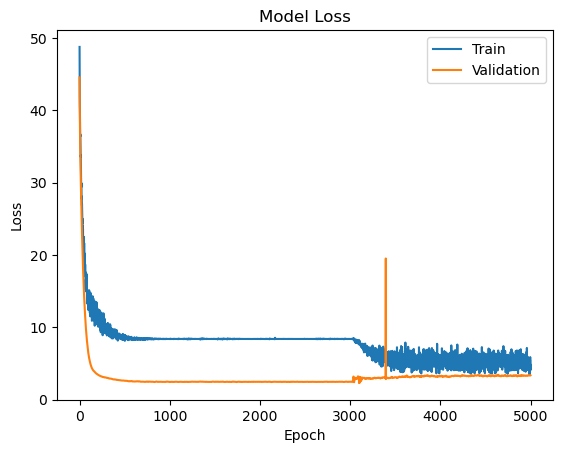

In [756]:
plt.plot(a.history['loss'], label='Train')
plt.plot(a.history['val_loss'], label='Validation')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Model Loss')
plt.legend(loc='upper right')

In [757]:
Y_pred=model.predict(X_test.astype(np.float32))

3/3 [==============================] - 0s 3ms/step


In [758]:
from sklearn.metrics import mean_squared_error

df_result=pd.DataFrame()
df_result['Ground_Truth']=Y_Test.reshape(1,-1)[0]
df_result['NN_Prediction']=Y_pred.reshape(1,-1)[0]
df_result=df_result.dropna(how='any')

#Mean Squared error of neural network prediction:
print("Mean Squared Error of neural network prediction: "+str(mean_squared_error(df_result['Ground_Truth'],df_result['NN_Prediction'])))
print("Mean absolute percentage error: "+str(mean_absolute_percentage_error(df_result['Ground_Truth'],df_result['NN_Prediction'])))
print("Mean absolute error: "+str(mean_absolute_error(df_result['Ground_Truth'],df_result['NN_Prediction'])))


Mean Squared Error of neural network prediction: 8.638219167432585
Mean absolute percentage error: 0.5477730626962124
Mean absolute error: 2.5467244681886387


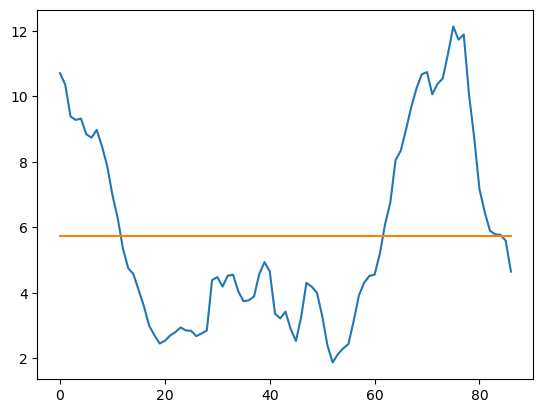

In [760]:
plt.plot(Y_Test)
plt.plot(Y_pred)